# Test of class Hamiltonian_QED

!!! Qiskit version < 0.24.0 Deprecated functions not yet active. !!!

In [257]:
import qiskit

In [258]:
qiskit.__version__

'0.24.1'



This notebook uses the class in 'Hamiltonian_QED.py' that builds the Hamiltonian in terms of Pauli matrices.

The code import the class in 'HC_Lattice.py' (that defines the lattice) and then is uses the Gray encoding for gauge fields (E and U) and Jordan-Wigner formulation for fermionic degrees of freedom.

In [259]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [260]:
from scipy.sparse.linalg import eigsh
from qiskit.quantum_info import Statevector
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../") # go to parent dir

In [341]:
from Hamiltonian_QED import HamiltonianQED
from HC_Lattice import HCLattice

In [465]:
#class input parameters:
n_sites = [2,2,]#how many sites for every dimension
g=1
fact_e_op = 1
fact_b_op = 1
m=3
omega=1
l=1
L=2
rotors = False
lambd = 1000
encoding = 'gray' #'ed'#
magnetic_basis=False
pbc=True
puregauge = False #TODO check when true
static_charges_values =None#{(0,0):-1,(1,0):1}
display_hamiltonian=False
e_op_out_plus=False #if E out of site n has plus sign 
tn_comparison = False #TODO only kept for TN comparison, remove later

#exact diagonalisation parameters:
threshold = 1e-12
num_eigs = 5

In [466]:
latt = HCLattice(n_sites,pbc=pbc)

In [467]:
class_H = HamiltonianQED(
                        latt,
                        n_sites,
                        l,
                        ll=L,
                        encoding = encoding,
                        rotors=rotors,
                        magnetic_basis=magnetic_basis,
                        pbc=pbc,
                        puregauge=puregauge,
                        static_charges_values=static_charges_values,
                        e_op_out_plus = e_op_out_plus,
                        display_hamiltonian=display_hamiltonian,
                        tn_comparison=tn_comparison)

HamiltonianQED: Initializing...
> Gauss law equations solved
> e_op_free and u_op_free built
> Pauli strings built
>> Gauss law applied and Hamiltonian built.  Execution time: 0.10139679908752441 seconds
>> Suppression term built.  Execution time: 0.005378007888793945 seconds


##### E U for ED

In [20]:
#TODO per ED usare queste def. di E e U scalano meglio

In [21]:
l=1
size_op = (2*l+1)

In [22]:
def e_ed_fun(l):
    return np.diag(np.arange(-l,l+1))

e_ed = e_ed_fun(l)

In [103]:
def u_ed_fun(l):
    size_op = (2*l+1)
    u_ed = np.zeros((size_op,size_op))
    # Fill the upper diagonal with 1s: U
    for i in range(size_op-1):
        u_ed[i,i+1] = 1
    return u_ed

u_ed = u_ed_fun(l)

In [24]:
def u_ed_dag_fun(l):
    u_ed_dag = np.zeros((2*l+1,2*l+1))
    # Fill the lower diagonal with 1s: U_dag
    for i in range(2*l):
        u_ed_dag[i+1,i] = 1
    return u_ed_dag

u_ed_dag =u_ed_dag_fun(l)

In [25]:
u_ed@np.array([1]+[0]*(2*l)) 

array([0., 0., 0.])

In [26]:
u_ed_dag@np.array([1]+[0]*(2*l)) 

array([0., 1., 0.])

##### Test el basis

In [27]:
from sympy import symbols,Symbol,Pow,Float,Integer,lambdify

In [400]:
encoding ='ed'#'gray'

In [352]:
def el_op_enc(encoding):
    """Return the encoding of the electric field operator in the chosen encoding"""
    if encoding=='gray':
        return class_H.str_to_pauli(class_H._r_c()[1], class_H._n_qubits_g())
    elif encoding=='ed':
        return e_ed_fun(l)
    else:
        raise ValueError('encoding not recognized')

def u_op_enc(encoding):
    """Return the encoding of the link operator in the chosen encoding"""
    if encoding=='gray':
        return class_H.str_to_pauli(class_H._l_c(), class_H._n_qubits_g())
    elif encoding=='ed':
        return u_ed_fun(l)
    else:
        raise ValueError('encoding not recognized')

def u_op_dag_enc(encoding):
    """Return the encoding of the link operator dagger in the chosen encoding"""
    if encoding=='gray':
        return class_H.str_to_pauli(class_H._l_c(), class_H._n_qubits_g()).adjoint()
    elif encoding=='ed':
        return u_ed_dag_fun(l)
    else:
        raise ValueError('encoding not recognized')

def hermitian_c(expr):
    """Compute hermitian conjugate of input expr."""

    if isinstance(expr,np.ndarray):
        return np.conj(expr).T 
    elif isinstance(expr,SparsePauliOp):
        return expr.adjoint()
    else:
        raise ValueError('encoding not recognized for hermitian conjugate')

In [401]:
eop1 = el_op_enc(encoding)
uop1 = u_op_enc(encoding)
uop1_dag = u_op_dag_enc(encoding)

In [374]:
from qiskit.quantum_info import Pauli,SparsePauliOp

In [403]:
_e_op_elem = lambda i: class_H._e_operator(index=i + 1)

#list of symbols only (encoding not needed)
eop_list = class_H.e_op_free if not class_H.rotors else class_H.rotor_list
uop_list = class_H.u_op_free if not class_H.rotors else [] 
qop_list =[] if class_H.puregauge else  [ symbols("q_" + class_H.str_node_f(k)) for k in class_H.lattice.jw_sites ] 
phiop_list = [ Symbol(f"Phi_{i+1}", commutative=False) for i, k in enumerate(class_H.lattice.jw_sites) ]

q10 = -0.5 * (class_H.I + class_H.Z)  # JW dependent
q00 = 0.5 * (class_H.I - class_H.Z)

sum_k = lambda k: k if latt.dims == 1 else sum(k)

#list of symbols and operators
qcharge_list = [(symbols("q_" + class_H.str_node_f(k)), (q10 if sum_k(k) % 2 else q00)) for k in class_H.lattice.jw_sites ]
e_field_list = [(s_tmp,eop1) for s_tmp in eop_list]
u_field_list = [(s_tmp,(uop1_dag if s_tmp.name[-1]=='D' else uop1)) for s_tmp in uop_list+class_H.u_op_free_dag]
phi_el = lambda i, j: HamiltonianQED.pauli_tens((
                class_H.jw_funct(i + 1, int(class_H.lattice.n_sitestot))[j]
            ) , )

phi_jw_list = [ ( Symbol(f"Phi_{i+1}D", commutative=False), phi_el(i, 0), ) for i, k in 
                enumerate(class_H.lattice.jw_sites) ] + [ ( Symbol(f"Phi_{i+1}", commutative=False), phi_el(i, 1), ) 
                for i, k in enumerate(class_H.lattice.jw_sites) ]

In [376]:
SPARSE_PAULI = qiskit.quantum_info.operators.symplectic.sparse_pauli_op.SparsePauliOp

In [377]:
dim_qubit_space = class_H.len_e_op*(class_H._n_qubits_g()) if class_H.puregauge else latt.n_sitestot + class_H.len_e_op*(class_H._n_qubits_g()) ;dim_qubit_space

4

In [378]:
import re

In [408]:
def list_to_pauli_ham(list_el,subst,ferm_lst=[],gauge_lst=[],encoding='gray'):
    """Return a list of Pauli operators from a list of symbolic operators.
    It consider only sparse pauli for single operator, not entire pauli string, thus operation like (I^op^I)**2 and I^op1^I*I^op2^I are
    then simplied to I^(op**2)^I and I^(op1*op2)^I, respectively.
    Last part is put everything together and add identity matrices where needed.
    
    encoding: gray, ed (exact diagonalization)"""
    ham_el = []
    for ei in list_el:
        index_op = [] #build index list order ..q2q1q0 (little endian)
        for e in ei:
            if not isinstance(e, (int, float, complex,Float,Integer,str)):
                if list(e.free_symbols)[0].name[-1]=='D' and list(e.free_symbols)[0].name[0]=='U':#gauge field U adjoint
                    index_op.append(str((ferm_lst[::-1] + [Symbol(i.name+'D') for i in gauge_lst][::-1]).index(*e.free_symbols))+'D')
                elif list(e.free_symbols)[0].name[-1]=='D' and list(e.free_symbols)[0].name[0:3]=='Phi':#fermion adjoint (but JW index only 0, must cover all the fermionic dof)
                    index_op.append(str(([Symbol(i.name+'D', commutative=False) for i in ferm_lst][::-1] + gauge_lst[::-1]).index(*e.free_symbols))+'D')                   
                else:#no adjoint
                    index_op.append(str((ferm_lst[::-1] + gauge_lst[::-1]).index(*e.free_symbols)))
                    
        ei_func = lambdify(list(zip(*subst))[0], ei)
        pauli_ei = ei_func(*list(zip(*subst))[1])
        op_dct = {}
        numbers = []
        ct = 0
        for el in pauli_ei:#build dictionary of sparse pauli operators and their index
            if isinstance(el, (SparsePauliOp,np.ndarray)):
                op_dct[index_op[ct]] = el
                ct+=1
            else:
                numbers.append(el)
        #print(op_dct,index_op,pauli_ei)
        if subst[0][0]==Symbol('Phi_1D', commutative=False):#ferm
            res = ['id_f']*len(ferm_lst) + ['id_g']*class_H.len_e_op
            f_index_op = [i for i in index_op if int(re.findall('\d+', i )[0])<len(ferm_lst)]#select only fermionic dof
            #print(op_dct,f_index_op)
            res[0]=op_dct[f_index_op[0]]@op_dct[f_index_op[1]] #compute product between fermions dof when JW applied
            start = len(ferm_lst)

        else: #no JW
            res = ['id_q']*len(ferm_lst) + ['id_g']*class_H.len_e_op
            start = 0

        for i in range(start,len(res)): #only for gauge or charges q
            if str(i) in op_dct.keys() and isinstance(res[i],str):#fill res with SparsePauli
                res[i] = op_dct[str(i)]
            if str(i)+'D' in op_dct.keys() and isinstance(res[i],str):#fill res with SparsePauli
                res[i] = op_dct[str(i)+'D']

            if isinstance(res[i],str) and res[i]=='id_q':#remaining spots for charges are filled with I
                res[i]=class_H.I #single qubit for charge
            elif isinstance(res[i],str) and res[i]=='id_g':
                if encoding=='gray':
                    res[i]=class_H.tensor_prod(class_H.I ,(class_H._n_qubits_g()))#Gray encoding for E field
                elif encoding=='ed':#exact diagonaliz. dimensions of gauge fields 2l+1
                    res[i]=np.eye(2*l+1)
        res = [elem for elem in res if not isinstance(elem,str)]#remove id_f when JW applied



        ham_el.append(np.prod(numbers)*class_H.pauli_tens(*res))
    return ham_el

In [380]:
hamiltonian_m_pauli = sum([((-1) ** j)*el for j,el in enumerate(list_to_pauli_ham(class_H.hamiltonian_m_sym,phi_jw_list,phiop_list,encoding=encoding))])

In [381]:
#(class_H.hamiltonian_m_pauli - hamiltonian_m_pauli).simplify()

In [382]:
hamiltonian_k_1y = sum(list_to_pauli_ham([h[1:] for h in class_H.hamiltonian_k_sym if h[0] == "y"],phi_jw_list+u_field_list,phiop_list,uop_list,encoding=encoding))
hamiltonian_k_1x = sum(list_to_pauli_ham([h[1:] for h in class_H.hamiltonian_k_sym if h[0] == "x"],phi_jw_list+u_field_list,phiop_list,uop_list,encoding=encoding))

hamiltonian_k_pauli = (
                    0.5j * (hamiltonian_k_1x - hermitian_c(hamiltonian_k_1x))
                    - 0.5 * (hamiltonian_k_1y + hermitian_c(hamiltonian_k_1y))
                )

In [383]:
#(class_H.hamiltonian_k_pauli-hamiltonian_k_pauli).simplify() 

In [409]:
ham_el=list_to_pauli_ham([class_H.decompose_expression(i) for i in class_H.hamiltonian_el_subs],qcharge_list+e_field_list,qop_list,eop_list,encoding=encoding)
ham_el=(sum(ham_el)/2)

[array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), array([[1, 0, 0],
       [0, 0, 0],
       [0, 0, 1]])] [[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[array([[1, 0, 0],
       [0, 0, 0],
       [0, 0, 1]]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])] [[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[array([[-1,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  1]]), array([[-1,  0,  0],
       [ 0,  0,  0],
       [ 0,  0,  1]])] [[ 1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0 -1  0  0  0  0 

In [385]:
ham_mag = list_to_pauli_ham(class_H.hamiltonian_mag_subs,u_field_list,qop_list,uop_list,encoding=encoding)
ham_mag=((sum(ham_mag)+hermitian_c(sum(ham_mag)))/2)

In [243]:
#(class_H.hamiltonian_mag_pauli-ham_mag).simplify()

In [244]:
#(class_H.hamiltonian_el_pauli-ham_el).simplify()

##### Test mag basis

In [152]:
U_mag_subs = {**{el_uop:Symbol('E_'+el_uop.name[2:]) for el_uop in class_H.u_op_free},**{el_uop:Symbol('E_'+el_uop.name[2:-1]) for el_uop in class_H.u_op_free_dag}}

In [153]:
hamiltonian_mag_sym= [[U_mag_subs.get(item, item) for item in sublst if item != 1] for sublst in class_H.hamiltonian_mag_subs]

In [308]:
hamiltonian_mag_sym_mbasis

[[E_10y], [E_11y, E_01y], [E_10x, E_11x, E_10y], [E_11x, E_01y, E_10x, E_11y]]

In [301]:
#compute e^i alpha E
ei_class = class_H.matx_exp(class_H.str_to_pauli(class_H._r_c()[1], class_H._n_qubits_g()),1j*class_H.alpha)

hamiltonian_mag_pauli = []
for ei in hamiltonian_mag_sym:
    id_eop = [list(e_op_dict_mbasis.keys()).index(e) for e in ei]
    idx  = class_H.tensor_prod(class_H.I ,(class_H._n_qubits_g()))
    if len(ei) == 1:# cos 1 operator is enough and rest is I
        cos1 = [class_H.cos_oper(ei_class) if i in id_eop else class_H.tensor_prod(class_H.I ,(class_H._n_qubits_g())) for i in range(class_H.len_e_op)[::-1]] #inverse because little endian
    else:
        #compute cosine of multiple operators cos(E1+E2+...)=e^iE1 e^iE2 ... + e^-iE1 e^-iE2 ... /2
        cosn = class_H.cos_oper(class_H.pauli_tens(*[ei_class if i in id_eop else idx  for i in range(class_H.len_e_op)[::-1]][min(id_eop):max(id_eop) + 1])).simplify()
        hamiltonian_mag_pauli.append(class_H.pauli_tens(*[idx for i in range(class_H.len_e_op)[::-1]][max(id_eop) + 1:]+ [cosn]+ [idx for i in range(class_H.len_e_op)[::-1]][:min(id_eop)] ))

hamiltonian_mag_pauli = sum(hamiltonian_mag_pauli) if class_H.puregauge else class_H.pauli_tens(class_H.tensor_prod(class_H.I , (int(class_H.lattice.n_sitestot))),sum(hamiltonian_mag_pauli))

In [154]:
[el for el in hamiltonian_mag_sym_mbasis if el != []]

[[E_10y], [E_11y, E_01y], [E_10x, E_11x, E_10y], [E_11x, E_01y, E_10x, E_11y]]

In [155]:
eop_list = class_H.e_op_free if not class_H.rotors else class_H.rotor_list
_e_op_elem = lambda i: class_H._e_operator(index=i + 1)
e_op_dict_mbasis = dict([(Symbol(s_tmp), _e_op_elem(i)) if eop_list==class_H.rotor_list else (s_tmp, _e_op_elem(i)) for i, s_tmp in enumerate(eop_list)])

In [203]:
hamiltonian_mag_subs_mbasis = [[e_op_dict_mbasis.get(item, item) for item in sublst] for sublst in hamiltonian_mag_sym_mbasis]

In [32]:
from qiskit.quantum_info import Pauli,SparsePauliOp

In [80]:
hamiltonian_mag_pauli = []
for op in hamiltonian_mag_subs_mbasis[0]:
    print(op)
    hamiltonian_mag_pauli.append(cosine_operator(op))

SparsePauliOp(['IIIIIIIIII', 'IIIZIIIIII', 'IIZIIIIIII', 'IIZZIIIIII', 'IIIIIIIIII', 'IIIZIIIIII', 'IIZIIIIIII', 'IIZZIIIIII'],
              coeffs=[-0.25+0.j, -0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,
 -0.25+0.j,  0.25+0.j])


AttributeError: 'SparsePauliOp' object has no attribute 'shape'

In [58]:
eigenvalues, eigenvectors = eigs(hamiltonian_mag_subs_mbasis[0][0].to_matrix(sparse=True))
inv_eigenvectors = eigenvectors.conj().T

coeff1 = 1j*class_H.alpha

diagonal_matrix1 = np.diag(np.exp(coeff1 * eigenvalues))
exp_matrix1 = eigenvectors @ diagonal_matrix1 @ inv_eigenvectors

In [44]:
from scipy.sparse.linalg import eigs, inv

In [70]:
def cosine_operator(operators):
    """Compute the cosine of a matrix using the eigendecomposition,
    if single operator is passed, it returns the cosine of the operator: cos(operators)=exp(i*operators)+exp(-i*operators)/2
    if list of operators is passed, it returns the cosine of the sum of the operators: cos(sum(operators))=exp(i*sum(operators))+exp(-i*sum(operators))/2"""
    #input matrix can be a single operator or a list of operators
    
    coeff1 = 1j*class_H.alpha
    coeff2 = -1j*class_H.alpha

    if isinstance(operators, list):
        operators = sum(operators).to_matrix(sparse=True)

    eigenvalues, eigenvectors = eigs(operators.to_matrix(sparse=True))
    print('eigs')
    inv_eigenvectors = eigenvectors.conj().T

    diagonal_matrix1 = np.diag(np.exp(coeff1 * eigenvalues))
    print('diag1')
    diagonal_matrix2 = np.diag(np.exp(coeff2 * eigenvalues))
    exp_matrix1 = eigenvectors @ diagonal_matrix1 @ inv_eigenvectors
    print('exp1')
    exp_matrix2 = eigenvectors @ diagonal_matrix2 @ inv_eigenvectors

    oper = Operator((exp_matrix1+exp_matrix2)/2)
    print('oper')

    sparsep = SparsePauliOp.from_operator(oper)
    print('sparsep')

    return sparsep
    

In [126]:
from scipy.linalg import expm

def compute_matrix_exponential(matrix, coefficient):
    """Compute the matrix exponential of a matrix using the eigendecomposition"""
    eigenvalues, eigenvectors = np.linalg.eig(matrix)
    diagonal_matrix = np.diag(np.exp(coefficient * eigenvalues))
    exp_matrix = eigenvectors @ diagonal_matrix @ np.linalg.inv(eigenvectors)
    return exp_matrix

In [634]:
eop_test = []
for index in range(1,4):
    eop_test.append(class_H.pauli_tens(
                    class_H.tensor_prod(class_H.I ,(class_H._n_qubits_g() * (3 - index)))
                    , class_H.str_to_pauli(class_H._r_c()[1], class_H._n_qubits_g())
                    , class_H.tensor_prod(class_H.I, (class_H._n_qubits_g() * (index - 1)))
                ))

In [655]:
eop_test

[SparsePauliOp(['IIIIII', 'IIIIIZ', 'IIIIZI', 'IIIIZZ', 'IIIIII', 'IIIIIZ', 'IIIIZI', 'IIIIZZ'],
               coeffs=[-0.25+0.j, -0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,
  -0.25+0.j,  0.25+0.j]),
 SparsePauliOp(['IIIIII', 'IIIZII', 'IIZIII', 'IIZZII', 'IIIIII', 'IIIZII', 'IIZIII', 'IIZZII'],
               coeffs=[-0.25+0.j, -0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,
  -0.25+0.j,  0.25+0.j]),
 SparsePauliOp(['IIIIII', 'IZIIII', 'ZIIIII', 'ZZIIII', 'IIIIII', 'IZIIII', 'ZIIIII', 'ZZIIII'],
               coeffs=[-0.25+0.j, -0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,
  -0.25+0.j,  0.25+0.j])]

In [656]:
class_H._e_operator()

SparsePauliOp(['IIIIIIIIII', 'IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIIZZ', 'IIIIIIIIII', 'IIIIIIIIIZ', 'IIIIIIIIZI', 'IIIIIIIIZZ'],
              coeffs=[-0.25+0.j, -0.25+0.j, -0.25+0.j, -0.25+0.j,  0.25+0.j, -0.25+0.j,
 -0.25+0.j,  0.25+0.j])

In [ ]:
#TODO HERE: vedere come generalizzare eiSznoidx xk cosine_operator scala exp

In [137]:
def eiSz_noidx_1():
    """Exponential function for Sz
    Input args.: class_H.alpha - numerical coefficient"""

    sznoidx = class_H._r_c()[0]
    projterm = f"{1.0} " + " ".join(sznoidx[0][1])

    arg =  class_H.tensor_prod(class_H.I ,(class_H._n_qubits_g())) + (
        (math.cos(class_H.alpha * sznoidx[0][0]) + 1j * math.sin(class_H.alpha * sznoidx[0][0]) - 1)
        *  class_H.str_to_pauli([projterm], class_H._n_qubits_g())
    )

    for nn in range(1, 2 * class_H.l_par ):
        aux = sznoidx[nn]
        projterm = f"{1.0} " + " ".join(aux[1])
        arg = (
            (
                 class_H.tensor_prod(class_H.I ,(class_H._n_qubits_g()))
                + (
                    (math.cos(class_H.alpha * aux[0]) + 1j * math.sin(class_H.alpha * aux[0]) - 1)
                    *  class_H.str_to_pauli([projterm], class_H._n_qubits_g())
                )
            )
            @ arg
        ).simplify()

    return arg

re_psum = lambda op: 0.5 * (op + op.adjoint()).simplify()
im_psum = lambda op: -0.5j * (op - op.adjoint()).simplify()

def cosSz_noidx_1():
    """Cosine function for Sz
    Input args.: class_H.alpha - numerical coefficient"""
    return (re_psum(eiSz_noidx_1())).simplify()

def cosSz_noidx_3():
    """Cosine function for sum of 3 Sz (3 rotators system) gauge theory (w/o fermions)
    Input args.: class_H.alpha - numerical coefficient"""
    ei1 = eiSz_noidx_1()
    r1 = (re_psum(ei1)).simplify()
    i1 = (im_psum(ei1)).simplify()
    arg = r1 ^ r1 ^ r1
    arg -= r1 ^ i1 ^ i1
    arg -= i1 ^ r1 ^ i1
    arg -= i1 ^ i1 ^ r1
    return arg

In [177]:
compute_matrix_exponential(class_H.str_to_pauli(class_H._r_c()[1], class_H._n_qubits_g()),1j*class_H.alpha)

array([[0.30901699-0.95105652j, 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 1.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        1.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.30901699+0.95105652j]])

In [128]:
eiSz_noidx_1().to_matrix()

array([[0.30901699-0.95105652j, 0.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 1.        +0.j        ,
        0.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        1.        +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.        +0.j        ,
        0.        +0.j        , 0.30901699+0.95105652j]])

In [130]:
eiSz_noidx_1()

SparsePauliOp(['II', 'IZ', 'ZI', 'ZZ'],
              coeffs=[ 0.6545085+0.j        ,  0.       -0.47552826j,  0.       -0.47552826j,
 -0.3454915+0.j        ])

In [188]:
ei_rc = SparsePauliOp.from_operator(Operator(compute_matrix_exponential(class_H.str_to_pauli(class_H._r_c()[1], class_H._n_qubits_g()),1j*class_H.alpha)))

In [139]:
re_psum(ei_rc).simplify()

SparsePauliOp(['II', 'ZZ'],
              coeffs=[ 0.6545085+0.j, -0.3454915+0.j])

In [196]:
cosSz_noidx_1()

SparsePauliOp(['II', 'ZZ'],
              coeffs=[ 0.6545085+0.j, -0.3454915+0.j])

In [305]:
ei_class = class_H.matx_exp(class_H.str_to_pauli(class_H._r_c()[1], class_H._n_qubits_g()),1j*class_H.alpha)

In [306]:
#cos e ^I
class_H.pauli_tens(class_H.cos_oper(ei_class),class_H.cos_oper(ei_class),class_H.I)

SparsePauliOp(['IIIII', 'IIZZI', 'ZZIII', 'ZZZZI'],
              coeffs=[ 0.42838137+0.j, -0.22612712+0.j, -0.22612712+0.j,  0.11936438+0.j])

In [307]:
#cos (e^ I)
class_H.cos_oper(class_H.pauli_tens(ei_class,ei_class,class_H.I)).simplify()

SparsePauliOp(['IIIII', 'IIZZI', 'IZIZI', 'IZZII', 'ZIIZI', 'ZIZII', 'ZZIII', 'ZZZZI'],
              coeffs=[ 0.42838137+0.j, -0.22612712+0.j, -0.22612712+0.j, -0.22612712+0.j,
 -0.22612712+0.j, -0.22612712+0.j, -0.22612712+0.j,  0.11936438+0.j])

In [299]:

length = class_H.len_e_op
for ei in hamiltonian_mag_sym_mbasis:
    numbers = [list(e_op_dict_mbasis.keys()).index(e) for e in ei]
    idx  = class_H.tensor_prod(class_H.I ,(class_H._n_qubits_g()))
    if len(ei) == 1:# cos 1 operator is enough and rest is I
        print(numbers)
        cos1 = [class_H.cos_oper(ei_class) if i in numbers else class_H.tensor_prod(class_H.I ,(class_H._n_qubits_g())) for i in range(length)[::-1]] #inverse because little endian
        print(class_H.pauli_tens(*cos1))
    else:
        #compute cos(e^I^e) combinations and tesnor product with additional I's to match length of the system #TODO add fermions
        print(numbers,min(numbers),max(numbers))
        print(['ei_class' if i in numbers else 'I' for i in range(length)[::-1]][min(numbers):max(numbers) + 1])
        cosn = class_H.cos_oper(class_H.pauli_tens(*[ei_class if i in numbers else idx  for i in range(length)[::-1]][min(numbers):max(numbers) + 1])).simplify()
        #print(cosn)
        print(['I' for i in range(length)[::-1]][max(numbers) + 1:]+ ['ei_class' if i in numbers else 'I' for i in range(length)[::-1]][min(numbers):max(numbers) + 1]+ ['I' for i in range(length)[::-1]][:min(numbers)] )
        print(class_H.pauli_tens(*[idx for i in range(length)[::-1]][max(numbers) + 1:]+ [cosn]+ [idx for i in range(length)[::-1]][:min(numbers)] ))
        

[3]
SparsePauliOp(['IIIIIIIIII', 'IIZZIIIIII'],
              coeffs=[ 0.6545085+0.j, -0.3454915+0.j])
[0, 4] 0 4
['ei_class', 'I', 'I', 'I', 'ei_class']
['ei_class', 'I', 'I', 'I', 'ei_class']
SparsePauliOp(['IIIIIIIIII', 'IIIIIIIIZZ', 'IZIIIIIIIZ', 'IZIIIIIIZI', 'ZIIIIIIIIZ', 'ZIIIIIIIZI', 'ZZIIIIIIII', 'ZZIIIIIIZZ'],
              coeffs=[ 0.42838137+0.j, -0.22612712+0.j, -0.22612712+0.j, -0.22612712+0.j,
 -0.22612712+0.j, -0.22612712+0.j, -0.22612712+0.j,  0.11936438+0.j])
[2, 1, 3] 1 3
['ei_class', 'ei_class', 'ei_class']
['I', 'ei_class', 'ei_class', 'ei_class', 'I']
SparsePauliOp(['IIIIIIIIII', 'IIIIIIZZII', 'IIIIIZIZII', 'IIIIIZZIII', 'IIIIZIIZII', 'IIIIZIZIII', 'IIIIZZIIII', 'IIIIZZZZII', 'IIIZIIIZII', 'IIIZIIZIII', 'IIIZIZIIII', 'IIIZIZZZII', 'IIIZZIIIII', 'IIIZZIZZII', 'IIIZZZIZII', 'IIIZZZZIII', 'IIZIIIIZII', 'IIZIIIZIII', 'IIZIIZIIII', 'IIZIIZZZII', 'IIZIZIIIII', 'IIZIZIZZII', 'IIZIZZIZII', 'IIZIZZZIII', 'IIZZIIIIII', 'IIZZIIZZII', 'IIZZIZIZII', 'IIZZIZZIII', 'IIZZZIIZII',

In [227]:
e_op_dict_mbasis.keys()

dict_keys([E_11y, E_11x, E_10x, E_10y, E_01y])

In [148]:
(cosSz_noidx_3()-((class_H.pauli_tens(ei_rc,ei_rc,ei_rc)+class_H.pauli_tens(ei_rc,ei_rc,ei_rc).adjoint())/2)).simplify()

SparsePauliOp(['IIIIII'],
              coeffs=[0.+0.j])

In [201]:
(cosSz_noidx_3()-class_H.cos_oper(class_H.pauli_tens(ei_rc,ei_rc,ei_rc))).simplify()

SparsePauliOp(['IIIIII'],
              coeffs=[0.+0.j])

In [147]:
((class_H.pauli_tens(ei_rc,ei_rc,ei_rc)+class_H.pauli_tens(ei_rc,ei_rc,ei_rc).adjoint())/2).simplify()

SparsePauliOp(['IIIIII', 'IIIIZZ', 'IIIZIZ', 'IIIZZI', 'IIZIIZ', 'IIZIZI', 'IIZZII', 'IIZZZZ', 'IZIIIZ', 'IZIIZI', 'IZIZII', 'IZIZZZ', 'IZZIII', 'IZZIZZ', 'IZZZIZ', 'IZZZZI', 'ZIIIIZ', 'ZIIIZI', 'ZIIZII', 'ZIIZZZ', 'ZIZIII', 'ZIZIZZ', 'ZIZZIZ', 'ZIZZZI', 'ZZIIII', 'ZZIIZZ', 'ZZIZIZ', 'ZZIZZI', 'ZZZIIZ', 'ZZZIZI', 'ZZZZII', 'ZZZZZZ'],
              coeffs=[ 0.28037925+0.j, -0.14800212+0.j, -0.14800212+0.j, -0.14800212+0.j,
 -0.14800212+0.j, -0.14800212+0.j, -0.14800212+0.j,  0.078125  +0.j,
 -0.14800212+0.j, -0.14800212+0.j, -0.14800212+0.j,  0.078125  +0.j,
 -0.14800212+0.j,  0.078125  +0.j,  0.078125  +0.j,  0.078125  +0.j,
 -0.14800212+0.j, -0.14800212+0.j, -0.14800212+0.j,  0.078125  +0.j,
 -0.14800212+0.j,  0.078125  +0.j,  0.078125  +0.j,  0.078125  +0.j,
 -0.14800212+0.j,  0.078125  +0.j,  0.078125  +0.j,  0.078125  +0.j,
  0.078125  +0.j,  0.078125  +0.j,  0.078125  +0.j, -0.04123938+0.j])

In [ ]:
class_H.pauli_tens(class_H.tensor_prod(class_H.I,2),ei_rc,class_H.tensor_prod(class_H.I,2))

SparsePauliOp(['IIIIII', 'IIIZII', 'IIZIII', 'IIZZII'],
              coeffs=[ 0.6545085+0.j        ,  0.       -0.47552826j,  0.       -0.47552826j,
 -0.3454915+0.j        ])

In [142]:
((ei_rc + ei_rc.adjoint())/2).simplify()

SparsePauliOp(['II', 'ZZ'],
              coeffs=[ 0.6545085+0.j, -0.3454915+0.j])

In [16]:
from sympy import Integer,Mul,Pow,Float,Symbol
import math
from qiskit.quantum_info import Operator

In [ ]:
#TODO apply subs_hamilt_sym_to_pauli NCHE PER H_E VED funzione qua sotto

In [441]:
def decompose_expression(expr):
    """Decompose a sympy expression into a list of symbols and powers."""

    if isinstance(expr, (Symbol,Pow,Float,Integer)):
        return [expr]
    elif isinstance(expr, Mul):
        terms = expr.as_ordered_factors()
        result = [t if isinstance(t, (Symbol, Pow)) else t for t in terms]
        return result
    else:
        raise ValueError("Invalid expression type")

In [259]:
from sympy import Symbol,expand,lambdify,symbols,simplify

import re

#### lattice and ED spectrum

In [291]:
#NEW PAULI rules:
#SparsePauliOp @ only with other SparsePauliOp
#Pauli @ only with other Pauli
# tensor ^ only between Pauli not with numbers like before that I^2 ==II . not working anymore

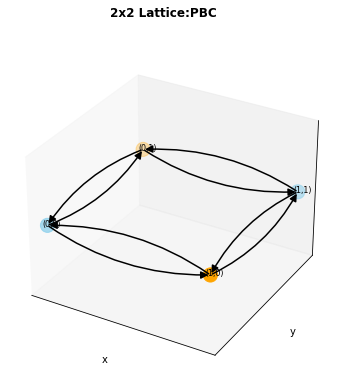

In [468]:
latt.draw_graph_func(gauss_law_fig=False)#,savefig_dir='.')

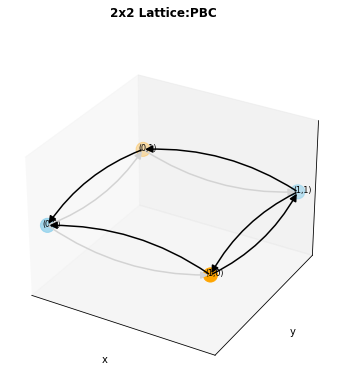

In [469]:
#only dynamical fields after Gauss law applied
latt.draw_graph_func(gauss_law_fig=True,e_op_free=class_H.e_op_free)#,savefig_dir='.')

In [462]:
len(class_H.e_op_free)

5

In [471]:
import scipy.sparse as sp
Hamiltonian_Pauli_tot = class_H.get_hamiltonian(g_var=g, m_var=m, omega=omega,fact_b_op=fact_b_op,fact_e_op=fact_b_op,lambd=lambd)

if encoding=='gray':
    Hamiltonian_Pauli_tot = Hamiltonian_Pauli_tot.to_matrix(sparse=True)
elif encoding=='ed':
    Hamiltonian_Pauli_tot = sp.csr_matrix(Hamiltonian_Pauli_tot)


In [472]:

h_b_sparse = class_H.hamiltonian_mag_pauli.to_matrix(sparse=True) if encoding=='gray' else sp.csr_matrix(class_H.hamiltonian_mag_pauli)
spectrum, eigenvectors_matrix = eigsh(Hamiltonian_Pauli_tot,k=num_eigs,which="SA",ncv = 30)#

idx = spectrum.argsort() 
spectrum = spectrum[idx]
eigenvectors_matrix = eigenvectors_matrix[:,idx]
print(f'Spectrum of H with pbc{pbc}_g{g}_l{l}_factE{fact_e_op}_factB{fact_b_op}_m{m}_Omega{omega}_TN{tn_comparison}')
eig0cj = eigenvectors_matrix[:,0].conj().T
eig0= eigenvectors_matrix[:,0]
plaq = (eig0cj.dot((h_b_sparse).dot(eig0)).real)/len(latt.plaq_list) 

for kk,evalu in enumerate(spectrum):
        if evalu<900:# only physical states, 1000 corresponds to factor of penalty term
                print(f'E_{kk}=',round(evalu,8))
                
                         

Spectrum of H with pbcTrue_g1_l1_factE1_factB1_m3_Omega1_TNFalse
E_0= -7.30371524
E_1= -6.55004296
E_2= -6.53959578
E_3= -6.49182022
E_4= -6.47101449


In [ ]:
#test ok 
Spectrum of H with pbcFalse_g1_l1_factE1_factB1_m3_Omega1_TNFalse
E_0= -0.43669289
E_1= 1.62553669
E_2= 1.98787437
E_3= 2.0
E_4= 2.0

Spectrum of H with pbcFalse_g1_l1_factE1_factB1_m3_Omega1_TNFalse
E_0= -9.69594846
E_1= -7.62047749
E_2= -7.27194179
E_3= -7.24864153
E_4= -7.22617728

Spectrum of H with pbcTrue_g1_l1_factE1_factB1_m3_Omega1_TNFalse
E_0= -7.30371524
E_1= -6.55004296
E_2= -6.53959578
E_3= -6.49182022
E_4= -6.47101449

In [ ]:
Spectrum of H with pbcTrue_g1_l1_factE1_factB1_m3_Omega1_TNTrue
E_0= -7.27136676
E_1= -6.37424805
E_2= -6.37396764
E_3= -6.3669531
E_4= -6.36507155

Spectrum of H with pbcTrue_g1_l1_factE1_factB1_m3_Omega1_phase_hkTrue_TNFalse
E_0= -7.30371524
E_1= -6.55004296
E_2= -6.53959578

In [223]:
plaq

0.4564902027748994